In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def partial_spearman_corr(df, x, y, controls):
    """Compute partial Spearman correlation between x and y given selected control variables."""
    from statsmodels.api import OLS, add_constant
    
    if controls:
        # Regress x and y on control variables
        residual_x = OLS(df[x], add_constant(df[controls])).fit().resid
        residual_y = OLS(df[y], add_constant(df[controls])).fit().resid
        return spearmanr(residual_x, residual_y)[0]
    else:
        return spearmanr(df[x], df[y])[0]

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_causal_graph(adj_matrix, df, ci_test):
    """
    Plots causal graph with edge color based on partial Spearman correlation values.
    Uses only relevant control variables.
    Displays actual correlation values (+/-0.XX) beside the edges.
    Draws arrows for one-way edges and lines for undirected (symmetric) edges.
    """
    nodes = df.columns
    G = nx.DiGraph()
    edge_info = []
    edge_labels = {}

    # Loop through all pairs
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                node_i = nodes[i]
                node_j = nodes[j]

                # Identify control variables
                related_vars = [nodes[k] for k in range(len(nodes)) if adj_matrix[k, j] or adj_matrix[k, i]]
                controls = [var for var in related_vars if var not in [node_i, node_j]]

                # Compute partial Spearman correlation
                pcorr = partial_spearman_corr(df, node_i, node_j, controls)

                # Determine edge color and width
                edge_color = '#F2C14E' if pcorr > 0 else '#8e7dbe'
                edge_width = 1 + 2 * abs(pcorr)

                G.add_edge(node_i, node_j, weight=pcorr)
                edge_info.append((node_i, node_j, edge_color, edge_width))
                edge_labels[(node_i, node_j)] = f"{pcorr:+.2f}"

    pos = nx.circular_layout(G)
    label_pos = {n: (p[0] * 1.2, p[1] * 1.2) for n, p in pos.items()}

    plt.figure(figsize=(11, 11), dpi=900)
    node_colors = ['#C9BFE1']  # default purple

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        edgecolors='white',
        node_size=500,
        alpha=0.9
    )
    nx.draw_networkx_labels(G, label_pos, font_size=16, font_family="arial", font_color='black')

    # Draw edges: check for symmetric edges
    handled_edges = set()
    for u, v, color, width in edge_info:
        if (v, u) in handled_edges:
            continue  # already handled symmetric pair

        arc_rad = 0.1

        if G.has_edge(v, u):
            
            # symmetric → undirected style
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='-', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))
        else:
            # one-way → directed arrow
            nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], width=width, edge_color=color,
            arrowstyle='simple', arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
            min_source_margin=20, min_target_margin=20
            )
            handled_edges.add((u, v))

    # Edge labels
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=14,
        font_color='black',
        font_family="arial",
        rotate=True,
        label_pos=0.5,
        bbox=dict(facecolor='none', edgecolor='none', pad=0)
    )

    # Legend
    pos_patch = mpatches.Patch(color='#F2C14E', label='Positive Causality')
    neg_patch = mpatches.Patch(color='#8e7dbe', label='Negative Causality')
    plt.legend(handles=[pos_patch, neg_patch], loc='lower left', fontsize=14, frameon=False)

    plt.gca().margins(x=0.3, y=0.3)
    plt.axis('off')
    plt.show()

In [4]:
import numpy as np
import pandas as pd
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]
    sami_col = df_select.columns[df_select.columns.str.contains("SAMI", case=False)][0]

    dfp = df_select.pivot(index=["cbsacode",'Year'], columns="factor", values=sami_col).reset_index()
    df_cleaned = dfp.drop(columns=["cbsacode",'Year'])  # Reverse column order as in original code
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(variant='stable', alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=df_cleaned.columns)

    result = pc._results
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, df_cleaned,ci_test)
    
    return result

In [11]:
def run_pc_with_stability(df, factor_list, alpha=0.01, ci_test='spearman',
                          n_runs=20, stability_threshold=0.8, verbose=True):
    """
    Run PC multiple times with shuffled factor orders and return stable edges.
    
    Returns:
        stable_adj: binary adjacency matrix of stable edges
        edge_freq: frequency matrix (values in [0,1])
        final_graph: last PC object (optional use)
    """
    num_vars = len(factor_list)
    edge_counts = np.zeros((num_vars, num_vars))
    sami_col = df.columns[df.columns.str.contains("SAMI", case=False)][0]

    for run in range(n_runs):
        shuffled = factor_list.copy()
        shuffle(shuffled)

        # Pivot and prepare matrix
        df_sub = df[df['factor'].isin(shuffled)]
        dfp = df_sub.pivot(index=['cbsacode', 'Year'], columns='factor', values=sami_col).reset_index()
        dfp = dfp.sort_values(['cbsacode', 'Year'])
        df_clean = dfp.drop(columns=['cbsacode', 'Year'])
        data_matrix = df_clean.to_numpy()

        # Run PC
        pc = PC(variant='stable', alpha=alpha, ci_test=ci_test)
        pc.learn(data_matrix, columns=df_clean.columns)

        # Count edge presence
        edge_counts += (pc.causal_matrix != 0).astype(int)

        if verbose:
            print(f"Run {run+1}/{n_runs} complete.")

    # Frequency matrix (how often each edge appears)
    edge_freq = edge_counts / n_runs

    # Threshold to keep only stable edges
    stable_adj = (edge_freq >= stability_threshold).astype(int)


    print("Learned skeleton (CPDAG):")
    plot_causal_graph(stable_adj, df_clean,ci_test)

    return stable_adj, edge_freq

# SASAMI

In [6]:
df = pd.read_csv('../00_data/03_analysis_data/sasami_result_0403.csv')
df.loc[df['factor'] == 'Park_Area_Acres', 'factor'] = 'PARK'
df.loc[df['factor'] == 'noise90n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'no_time_activity', 'factor'] = 'PI'
df.loc[df['factor'] == 'smo_obe_dia', 'factor'] = 'UNH'
df.loc[df['factor'] == 'depressed', 'factor'] = 'DEP'
df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'

In [7]:
my_factors = ['GDP','NOI','PARK','PI','UNH','DEP','MHP']

In [8]:
pc_result= run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='spearman')

Learned skeleton (CPDAG):


In [13]:
pc_result2 = run_pc_with_stability(df, my_factors, alpha=0.01, ci_test='spearman',
                          n_runs=100, stability_threshold=0.8, verbose=True)


Run 1/100 complete.
Run 2/100 complete.
Run 3/100 complete.
Run 4/100 complete.
Run 5/100 complete.
Run 6/100 complete.
Run 7/100 complete.
Run 8/100 complete.
Run 9/100 complete.
Run 10/100 complete.
Run 11/100 complete.
Run 12/100 complete.
Run 13/100 complete.
Run 14/100 complete.
Run 15/100 complete.
Run 16/100 complete.
Run 17/100 complete.
Run 18/100 complete.
Run 19/100 complete.
Run 20/100 complete.
Run 21/100 complete.
Run 22/100 complete.
Run 23/100 complete.
Run 24/100 complete.
Run 25/100 complete.
Run 26/100 complete.
Run 27/100 complete.
Run 28/100 complete.
Run 29/100 complete.
Run 30/100 complete.
Run 31/100 complete.
Run 32/100 complete.
Run 33/100 complete.
Run 34/100 complete.
Run 35/100 complete.
Run 36/100 complete.
Run 37/100 complete.
Run 38/100 complete.
Run 39/100 complete.
Run 40/100 complete.
Run 41/100 complete.
Run 42/100 complete.
Run 43/100 complete.
Run 44/100 complete.
Run 45/100 complete.
Run 46/100 complete.
Run 47/100 complete.
Run 48/100 complete.
R

In [14]:
pc_result2

(array([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]]),
 array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]]))

In [12]:
my_factors

['PARK', 'NOI', 'PI', 'UNH', 'DEP', 'GDP', 'MHP']

In [13]:
pc_result

[(0, 1, [], -0.20674053781710228, 8.542704680088913e-10),
 (0, 2, [], 0.20973157146992868, 4.807472605527476e-10),
 (0, 3, [], 0.18717385301252146, 2.9757470454803297e-08),
 (0, 4, [], 0.012238286183356142, 0.7194280176371604),
 (0, 5, [], 0.2603951168832715, 7.397170077344825e-15),
 (0, 6, [], -0.08229352953915745, 0.015540627538721898),
 (1, 2, [], 0.20612499451138688, 9.605382317722535e-10),
 (1, 3, [], -0.06032202689823527, 0.07637044993061326),
 (1, 4, [], -0.15535243966060647, 4.481991681183321e-06),
 (1, 5, [], -0.23287109908453651, 4.191354269239629e-12),
 (1, 6, [], 0.01857326200741093, 0.5856181481315514),
 (2, 3, [], 0.03535032675492335, 0.29931509981054355),
 (2, 4, [], 0.00210777626701377, 0.9506694718943163),
 (2, 5, [], -0.16627719840350197, 8.891502554475945e-07),
 (2, 6, [], -0.0042274972445301776, 0.9012494074508887),
 (3, 4, [], -0.0726357251675287, 0.0327793958736805),
 (3, 5, [], 0.06448398777531394, 0.05813712765390492),
 (3, 6, [], 0.04524586222624206, 0.18394485

In [28]:
records = []
for (x_idx, y_idx,cond_indices,corr, p_val ) in pc_result:
    # Convert x_idx and y_idx to factor names:
    x_name = my_factors[x_idx]
    y_name = my_factors[y_idx]
    # Convert conditioning indices (if any) to factor names:
    cond_names = [my_factors[z] for z in cond_indices]

    records.append({
        "X": x_name,
        "Y": y_name,
        "Z":  cond_names,
        "Spearman":corr,
        "p value": p_val
    })

df = pd.DataFrame(records)


In [19]:
df.to_csv("../00_data/04_output/sasami_result.csv",index=False)

In [35]:
import pandas as pd
import ast

# Load your CSV
df = pd.read_csv("../00_data/04_output/sasami_result.csv")


# Clean Z column
def clean_z(z):
    try:
        items = ast.literal_eval(z)
        if isinstance(items, list) and len(items) == 0:
            return '-'
        elif isinstance(items, list):
            return ', '.join(str(i) for i in items)
    except:
        return z
    return z

# Apply formatting
df['Z'] = df['Z'].apply(clean_z)
df['Spearman'] = df['Spearman'].astype(float).apply(lambda x: f"{x:.2f}")
df['p value'] = df['p value'].astype(float).apply(lambda x: r"\textless{} 0.001" if x < 0.001 else f"{x:.3f}")

# Split side by side
half = len(df) // 2 + len(df) % 2
df1 = df.iloc[:half].reset_index(drop=True)
df2 = df.iloc[half:].reset_index(drop=True)
combined = pd.concat([df1, df2], axis=1)
combined.columns = ['X', 'Y', 'Z', 'Spearman', 'p value', 'X', 'Y', 'Z', 'Spearman', 'p value']

# Export to LaTeX
latex_code = combined.to_latex(
    index=False,
    column_format="|l|l|l|r|r||l|l|l|r|r|",
    escape=False
)

In [36]:
with open("sasami_table_final.tex", "w") as f:
    f.write(latex_code)

In [ ]:
pc_result = run_pc_analysis(df, factor_list=my_factors, alpha=0.01, shuffle_factors=True,ci_test='mutual_info')

ci_test is now: mutual_info
Learned skeleton (CPDAG):


In [1]:
my_factors = ['Depression',
    # health
    # 'excessive_drinking',
    # 'adult_obesity',
    # 'sti', 
    'Unhealthy Lifestyle',
    # 'smo_obe', 
    # 'smo_dia', 
    # 'obe_dia', 
    'Physical Inactivity', 

    # education
    # 'some_college',

    # economic
    # 'unemployment', #no direct link with depression
    'GDP', 
    # 'median_household_income', #add this the no time activity become result

    # health source
    'Mental Health Providers', 

    # social association
    # 'children_single_parent',

    # enviroment
    # 'driving_alone_to_work', 
    'Park Area',
    # 'Weighted_RESP', 
    # 'noise70n', 
    # 'noise80n', 
    'Noise', 
    
]

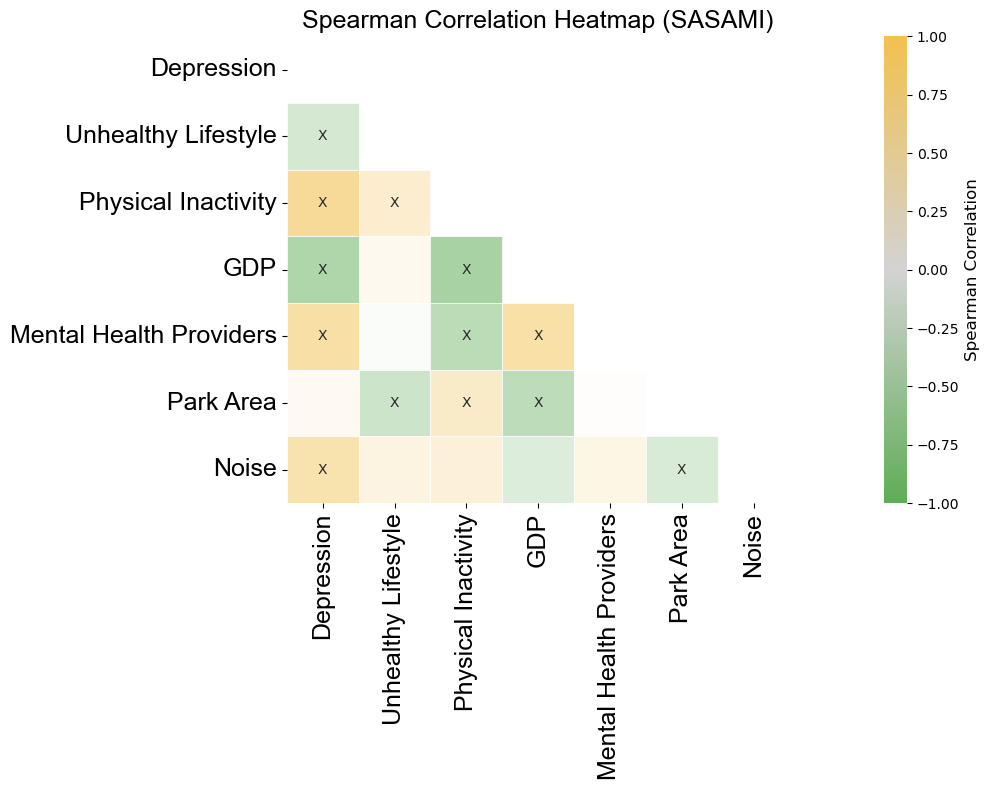

In [ ]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- 数据准备 ----

# 假设你已有 DataFrame `df`，并包含 'cbsacode'、'Year'、'factor'、'SSAMI'
# 和一个包含你要分析的 factor 名称列表：my_factors

# 透视表：行为 (cbsacode, Year)，列为 factor，值为 SSAMI
dfp = df.pivot(index=["cbsacode", "Year"], columns="factor", values="SSAMI").reset_index()
df_cleaned = dfp[my_factors]

# 因子列表（去掉 index 列）
factor_list = df_cleaned.columns.drop('cbsacode', errors='ignore')

# ---- 相关性和 p 值计算 ----

# 初始化空矩阵
spearman_corr = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)
p_values = pd.DataFrame(index=factor_list, columns=factor_list, dtype=float)

# 两两组合计算 Spearman 相关性
for f1, f2 in itertools.combinations(factor_list, 2):
    corr, p_value = spearmanr(df_cleaned[f1], df_cleaned[f2])
    spearman_corr.loc[f1, f2] = spearman_corr.loc[f2, f1] = corr
    p_values.loc[f1, f2] = p_values.loc[f2, f1] = p_value

# 对角线赋值为 1 和 p=1
np.fill_diagonal(spearman_corr.values, 1)
np.fill_diagonal(p_values.values, 1)

# ---- 注释矩阵和遮罩 ----

# 标记显著性：p ≤ 0.05 显示 'X'
annot_matrix = np.where(p_values.to_numpy() <= 0.05, 'X', '')

# 遮罩上三角
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# ---- 自定义颜色矩阵 ----

color_matrix = np.full(spearman_corr.shape, '', dtype=object)

for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            color_matrix[i, j] = '#FFFFFF00'  # 上三角透明
            continue

        pcorr = spearman_corr.iloc[i, j]
        p = p_values.iloc[i, j]

        if pd.isna(pcorr) or pd.isna(p):
            color_matrix[i, j] = '#FFFFFF00'
        elif p == 0:
            color_matrix[i, j] = '#D3D3D3'  # 浅灰
        else:
            # 透明度与相关系数强度相关（非线性缩放）
            alpha = min(1.0, abs(pcorr)**0.7 * 1.5)
            hex_color = '#F2C14E' if pcorr > 0 else '#5FAD56'
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))
            rgba_tuple = (rgb[0]/255, rgb[1]/255, rgb[2]/255, alpha)
            color_matrix[i, j] = rgba_tuple

# ---- 绘图 ----

fig, ax = plt.subplots(figsize=(10, 8))

# 白底 + 注释层
sns.heatmap(np.zeros_like(spearman_corr, dtype=float),
            annot=annot_matrix,
            fmt="",
            mask=mask,
            cmap="Greys",
            cbar=False,
            linewidths=0.5,
            ax=ax)

# 叠加矩阵色块
for i in range(spearman_corr.shape[0]):
    for j in range(spearman_corr.shape[1]):
        if mask[i, j]:
            continue
        ax.add_patch(plt.Rectangle((j, i), 1, 1,
                                   facecolor=color_matrix[i, j],
                                   edgecolor='white', lw=0.5))

from matplotlib import font_manager

# 设置字体
font_prop = font_manager.FontProperties(family='Arial',size=18)

# 标题
ax.set_title("Spearman Correlation Heatmap (SASAMI)", fontproperties=font_prop)

# 坐标轴刻度位置
ax.set_xticks(np.arange(len(spearman_corr.columns))+0.5)
ax.set_yticks(np.arange(len(spearman_corr.index)) + 0.5)

# 坐标轴标签文字及字体
ax.set_xticklabels(spearman_corr.columns, rotation=90, ha="center", fontproperties=font_prop)
ax.set_yticklabels(spearman_corr.index, rotation=0, fontproperties=font_prop)

# ---- 图例（可选）----

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 创建颜色映射：负相关 -> 灰色 -> 正相关
cmap = LinearSegmentedColormap.from_list("corrmap", ['#5FAD56', '#D3D3D3', '#F2C14E'])
norm = Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# 添加横向 colorbar 放在图底部
cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.15)
cbar.set_label("Spearman Correlation", fontsize=12)
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()
